<a href="https://colab.research.google.com/github/TheoMonpouet/DD2365/blob/main/Project_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Template by: Johan Hoffman**

**Report by: Theo Monpouet**

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

**Define domain and mesh**

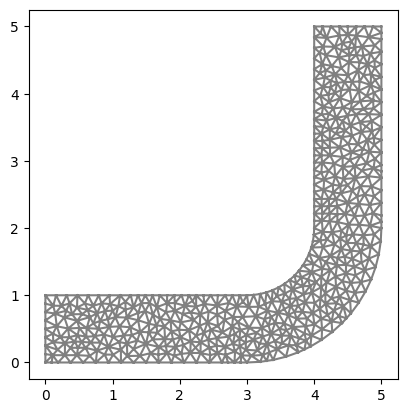

In [ ]:
# Define rectangular domain
L = 5
B = 1

# Define circle
xc = 1.0
# yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], B)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32

# mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,B)) + Rectangle(Point(L-B,L), Point(L, B)) - Circle(Point(1, 0.5), 0.2), resolution) # TURBULENT
# mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,B)) + Rectangle(Point(L-B,L), Point(L, B)), resolution) # SHARP BOTH
# mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,B)) + Rectangle(Point(L-B,L), Point(L, B)) + Rectangle(Point(L-2*B, 2*B), Point(L-B, B)) - Circle(Point(L-2*B+0.1, 2*B-0.1), B), resolution)

# CIRCLE OUTER
domain = Rectangle(Point(0.0, 0.0), Point(L-B-B, B)) + \
         Rectangle(Point(L - B, L), Point(L, 2*B)) + \
         Circle(Point(L - 2*B, 2*B), 2*B, resolution*2) - \
         Rectangle(Point(0, L), Point(L-B, B)) + \
         Rectangle(Point(L - 2*B, 2*B), Point(L - B, B)) - \
         Circle(Point(L - 2*B, 2*B), B, resolution*2)


# CIRCLE INNER
# domain = Rectangle(Point(0.0, 0.0), Point(L, B)) + \
#          Rectangle(Point(L - B, L), Point(L, B)) + \
#          Rectangle(Point(L - 2*B, 2*B), Point(L - B, B)) - \
#          Circle(Point(L - 2*B, 2*B), B, resolution*2)

mesh = generate_mesh(domain, resolution)


# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    # if p.distance(Point(L-B-0.3, B+0.5)) < 1.3 or (p[1] < 1.1 and p[1] > 0.9):
    if p.distance(Point(L-B-0.3, B+0.5)) < 1.3 or (p[1] < 1.1 and p[1] > 0.9):
      cell_marker[cell] = True

  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)


# plt.figure()
# plot(mesh)
# plt.axis([2.5, 3.5, 1.5, 2.5])
# plt.show()

# plt.figure()
# plot(mesh)
# plt.axis([1.5, 2.5 , 0.5, 1.5])
# plt.show()

plt.figure()
plot(mesh)

plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions


class wallBC(SubDomain):
  def inside(self, x, on_boundary):
    if near(x[0], 0.0) and (near(x[1], B) or near(x[1], 0.0)):
      return on_boundary

    return on_boundary and not (near(x[0], 0.0) or near(x[1], L))

class inletBC(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0], 0.0) and not near(x[1], B) and not near(x[1], 0.0)

class outletBC(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], L)


uin = 5

bc_inlet_x = DirichletBC(V.sub(0), uin, inletBC())
bc_inlet_y = DirichletBC(V.sub(1), 0.0, inletBC())

bc_wall_x = DirichletBC(V.sub(0), 0.0, wallBC())
bc_wall_y = DirichletBC(V.sub(1), 0.0, wallBC())



bc_outlet = DirichletBC(Q, 0.0, outletBC())


bcu = [bc_wall_x, bc_wall_y, bc_inlet_x, bc_inlet_y]
bcp = [bc_outlet]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

In [ ]:

# class DirichletBoundaryLower(SubDomain):
#     def inside(self, x, on_boundary):
#         return on_boundary and near(x[1], 0.0)

# class DirichletBoundaryUpper(SubDomain):
#     def inside(self, x, on_boundary):
#         return on_boundary and near(x[1], H)

# class DirichletBoundaryLeft(SubDomain):
#     def inside(self, x, on_boundary):
#         return on_boundary and near(x[0], 0.0)

# class DirichletBoundaryRight(SubDomain):
#     def inside(self, x, on_boundary):
#         return on_boundary and near(x[0], L)

# class DirichletBoundaryObjects(SubDomain):
#     def inside(self, x, on_boundary):
#         return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))





# dbc_lower = DirichletBoundaryLower()
# dbc_upper = DirichletBoundaryUpper()
# dbc_left = DirichletBoundaryLeft()
# dbc_right = DirichletBoundaryRight()
# dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)

# uin = 1
# bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
# bcu_in1 = DirichletBC(V.sub(1), 0, dbc_left)

# bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
# bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)

# bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
# bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)

# bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
# bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)


# pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
# pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
# bcp1 = DirichletBC(Q, pout, dbc_right)


# bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
# bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
# bcp = [bcp1]



# **Results**

**Define flow parameters**

In [ ]:
# Set viscosity
nu = 4.0e-4

In [ ]:
Reynolds = uin * 2 * rc / nu
print("Re=", Reynolds)

Re= 5000.0


**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin() # ändra 0.5

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 200

# Force computation data
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
force_array2 = np.array(0.0)
force_array2 = np.delete(force_array2, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
!rm results-NS/*

# Time stepping
T = 7
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    # pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        # F = assemble(Force)
        # F2 = assemble(Force2)
        # if (t > start_sample_time):
        #   force_array = np.append(force_array, normalization*F)
        #   force_array2 = np.append(force_array2, normalization*F2)
        #   time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        # plt.figure()
        # plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()

        # plt.figure()
        # plt.title("Lift force")
        # plt.plot(time, force_array)
        # plt.show()

        # plt.figure()
        # plt.title("Drag force")
        # plt.plot(time, force_array2)
        # plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')

# **Discussion**